### 2차 미분을 사용한 방법(헤시안 행렬)
특징점을 구하는 또 다른 방법으로는 2차 미분을 사용한 방법이 있다.  
이 방법에서는 아래의 헤시안 행렬(Hessian matrix)를 사용한다.

$$
\mathbf{H} = \begin{pmatrix}d_{yy} & d_{yx} \\ d_{yx} & d_{xx} \end{pmatrix}
$$

여기서 d(yy)와 d{xx}는 각각 y방향과 x방향으로 두 번 미분한 2차 도함수를 말하고 d(yx)는 y방향으로 미분한 후 그 결과를 다시 x방향으로 미분한 도함수이다.

미분을 사용할 때의 주의점은 미분이 잡음을 증폭시킨다는 것이다. 심지어 2차 미분이므로 이를 바로 이미지에 적용하지 않는다. 대신 가우시안으로 스무딩을 거친 다음 그 결과에 2차 미분을 수행한다. 식으로 표현하면 다음과 같다.

$$
\mathbf{H} = \begin{pmatrix}d_{yy}(\sigma) & d_{yx}(\sigma) \\ d_{yx}(\sigma) & d_{xx}(\sigma) \end{pmatrix}
$$

$$
where, d_{st}(\sigma) = \frac{\partial}{\partial t} \left( \frac{\partial}{\partial s}(G(y,x,\sigma) \circledast f(y,x))\right)
$$

헤시안에서는 보통 두 종류의 값을 계산하는데 이들이 특징 가능성 값에 해당한다. 2번째 식은 LOG(Laplacian of Gaussian)는 [에지 검출에 사용하였던 연산자](https://github.com/Songminkee/computer_vision/blob/master/zero_crossing.ipynb)와 같은 것이다. 이 연산자는 에지 근방에서 특징점이 많이 발생하므로, 에지를 걸러 주는 후처리가 따로 필요하다(이 방법은 나중에 다룬다).

- 헤시안의 행렬식(Determinant)  
$$
C=det(\mathbf{H}) = d_{yy}(\sigma)d_{xx}(\sigma)-d_{yx}(\sigma)^2
$$
- 가우시안 라플라시안(LOG)  
$$
C = \nabla^2 = trace(\mathbf{H}) = d_{yy}(\sigma) + d_{xx}(\sigma)
$$

### 슈산(SUSAN)
SUSAN(Smallest Univalue Segment Assimilating Nucleus) 방식은 현재 처리 중인 중심점과 인근 지역의 밝기 값이 얼마나 유사한가를 따져 보고 그 결과에 따라 특징일 가능성을 측정한다.

SUSAN에서는 중심점에 원형 마스크를 씌우고 중심점과 명암값이 유사한 점으로 구성된 영역을 USAN(Univalue Segment Assimilating Nucleus)라 부른다. SUSAN은 마스크와 우산의 크기 비율을 측정한 후, 50% 정도인 곳을 에지, 50%보다 작은 곳을 코너로 검출한다.

결국 SUSAN 검출 알고리즘의 핵심은 아래의 식에 해당하는 우산의 크기를 측정해 주는 연산이다.

$$
usan_area(r_{0}) = \sum_{r}(r,r_{0})
$$

$$
where, s(r,r_{0}) = \begin{cases}1, \begin{vmatrix} f(r)-f(r_{0}) \end{vmatrix} \le f_{1} \\ 0, Othere wise \end{cases}
$$

여기서 usan_area는 중심점 r0에서 USAN의 크기이며 r은 원형 마스크 내의 화소들이다. 식에 따르면 usan_area(r0)는 명암값 차이가 t1 보다 작은 화소의 개수가 된다.

이제 USAN의 크기를 특징 가능성으로 표현해주기 위해 다음의 식을 사용한다.

$$
C = \begin{cases}q-usan \ area(r_{0}),\quad usan \ area(r_{0}) \le f_{2} \\ 0, \qquad \qquad \qquad \quad Other wise \end{cases}
$$

여기에서 t2는 보통 마스크 넓이의 50%로 설정하고, q는 0.75 x 마스크의 넓이로 설정한다.

[SUSAN - A New Approach to Low Level Image Processing_S.M.Smith(1997)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.27.8270&rep=rep1&type=pdf)에서는 아래와 같은 7x7 크기, 넓이 37를 갖는 원형 마스크를 사용했다. 그리고 SUSAN을 이용하여 에지를 검출할 때는 t2를 마스크 넓이의 75%로 설정한다. 
![](./data/susan_filter.jpg)


### 코드구현

구현은 다음의 사진에 대해 진행한다.

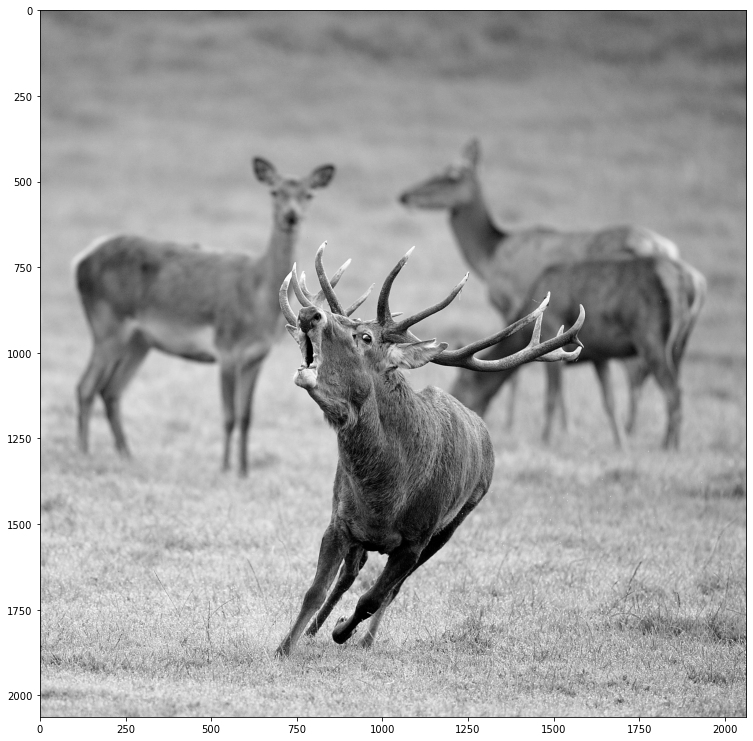

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from util import *

img =cv2.imread('./data/red_deer.jpg',cv2.IMREAD_GRAYSCALE)

fig = plt.figure(figsize=(13,13))
plt.imshow(img,cmap='gray')
plt.show()

구현 자체는 단순하다. 그저 위의 식을 따라하면 된다. Gaussian은 이전에 구현한 것을 그대로 썼다([참고](https://github.com/Songminkee/computer_vision/blob/master/util.py)). dy와 dx는 이전에 [Harris corner](https://github.com/Songminkee/studyblog/blob/master/_posts/cv/2020-06-22-harris.md)를 구현할 때 처럼 [-1,0,1] 마스크와 동일하게 동작하도록 구현했다. dy2와 dx2는 2차 미분에 해당하며 일차 미분한 이미지에서 동일한 작업을 한번 더 수행하면된다.

In [2]:
def Hessian_feature(img,threshold,sigma=1,kernel_size=3,max_value=255):
    # Gaussian Smoothing
    mask = get_gaussian_kernel(sigma,kernel_size)
    img = (conv(img,mask)/max_value).squeeze()

    # Second Derivative Y
    dy = np.pad(img[1:], ((0, 1), (0, 0))) - np.pad(img[:-1], ((1, 0), (0, 0)))
    dy2 = np.pad(dy[1:], ((0, 1), (0, 0))) - np.pad(dy[:-1], ((1, 0), (0, 0)))

    # Second Derivative X
    dx = np.pad(img[..., 1:], ((0, 0), (0, 1))) - np.pad(img[..., :-1], ((0, 0), (1, 0)))
    dx2 = np.pad(dx[..., 1:], ((0, 0), (0, 1))) - np.pad(dx[..., :-1], ((0, 0), (1, 0)))

    # Derivate Y and X
    dydx = np.pad(dy[..., 1:], ((0, 0), (0, 1))) - np.pad(dy[..., :-1], ((0, 0), (1, 0)))

    # Determinant of Hessian Matrix
    Determinant = dy2*dx2 - (dydx**2)
    
    # LOG (=Trace of Hessian Matrix)
    LOG = dy2+dx2
    return np.where(Determinant>threshold,Determinant,0), LOG

아래 그림은 0.1(threshold 값)을 경계로 검출된 특징점을 그린 그림이다. 그리는 함수는 이전에 Harris corner에서 구현한 "draw_harris_circle" 함수를 변경했다. 자세한 구현은 [util.py](https://github.com/Songminkee/computer_vision/blob/master/util.py)를 참고하면 된다.

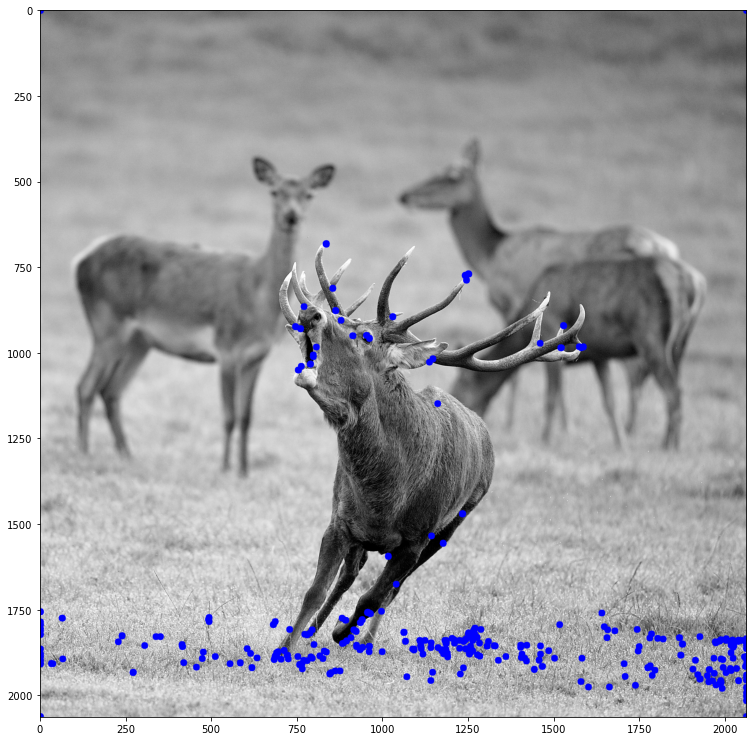

In [3]:
Det_C,LOG_C = Hessian_feature(img,0.1,1,7)

fig = plt.figure(figsize=(13,13))
plt.imshow(draw_featrue_point(img,Det_C))
plt.show()

다음의 그림은 이전에 구현한 [LOG](https://github.com/Songminkee/computer_vision/blob/master/zero_crossing.ipynb) 연산자와 Hessian LOG를 비교한 그림이다. 중간 수식에서 값의 차이가 있기 때문에 완전히 동일하게 구현된 것은 아니지만 이론상 같은 내용인 것을 확인하기 위해 구현했다.

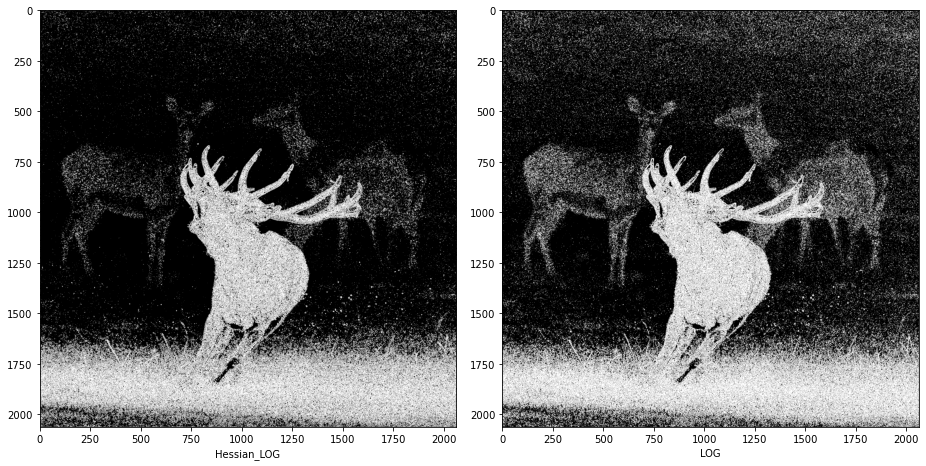

In [4]:
def Hessian_LOG_test(log_img,threshold=None):
    if threshold == None:
        threshold = np.max(log_img)*0.05
    e_img = np.pad(log_img[:,1:],((0,0),(0,1)))
    w_img = np.pad(log_img[:,:-1],((0,0),(1,0)))
    n_img = np.pad(log_img[:-1,:],((1,0),(0,0)))
    s_img = np.pad(log_img[1:, :], ((0,1), (0, 0)))
    se_img = np.pad(s_img[:,1:],((0,0),(0,1)))
    ne_img = np.pad(n_img[:, 1:], ((0, 0), (0, 1)))
    sw_img = np.pad(s_img[:,:-1],((0,0),(1,0)))
    nw_img = np.pad(n_img[:,:-1], ((0, 0), (1, 0)))

    w_vs_e = np.int8(np.logical_and(np.absolute(w_img-e_img)>=threshold,sign(w_img,e_img)))
    s_vs_n = np.int8(np.logical_and(np.absolute(n_img - s_img) >= threshold,sign(n_img,s_img)))
    sw_vs_ne = np.int8(np.logical_and(np.absolute(sw_img - ne_img) >= threshold,sign(sw_img,ne_img)))
    nw_vs_se = np.int8(np.logical_and(np.absolute(nw_img - se_img) >= threshold,sign(nw_img,se_img)))

    return np.uint8(w_vs_e+s_vs_n+sw_vs_ne+nw_vs_se>=1)*255

fig = plt.figure(figsize=(13,13))
plt.subplot(121)
plt.imshow(Hessian_LOG_test(LOG_C),cmap='gray')
plt.xlabel("Hessian_LOG")

plt.subplot(122)
plt.imshow(get_LOG_img(img,1),cmap='gray')
plt.xlabel("LOG")

fig.tight_layout()

plt.show()

다음은 SUSAN 알고리즘을 구현할 것이다. 먼저 USAN 넓이를 구하는 함수는 다음과 같이 된다. 구현은 이전에 구현했던 im2col을 참고해 구현했다.

In [10]:
def usan_area(img, filter,threshold,max_value=255):
    filter_h,filter_w = filter.shape
    if len(img.shape) == 3:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    H, W = img.shape
    img = np.expand_dims(img/max_value, -1)

    u_pad_h = (filter_h-1)//2
    d_pad_h = (filter_h-1)//2
    l_pad_w = (filter_w-1)//2
    r_pad_w = (filter_w-1)//2
    if (filter_h-1) %2 ==1:
        u_pad_h +=1
    if (filter_w-1)%2 ==1:
        l_pad_w +=1

    input_data = cv2.copyMakeBorder(img, u_pad_h, d_pad_h, l_pad_w, r_pad_w, cv2.BORDER_CONSTANT)
    input_data= np.expand_dims(input_data,-1)
    input_data = np.transpose(input_data,(2,0,1))
    col = np.zeros(( 1, filter_h, filter_w, H, W))

    for y in range(filter_h):
        y_max = y + H
        for x in range(filter_w):
            x_max = x + W
            col[:, y, x, :, :] = input_data[:, y:y_max:1, x:x_max:1]

    col = np.transpose(col,(0,3,4,1,2)).reshape(H*W, -1)
    usan = np.abs(np.transpose(img,(2,0,1)).reshape([-1,1]) - col*filter.reshape((1,-1)))<=threshold
    return np.sum(usan,axis=1).reshape(H,W)

SUSAN에서 사용한 원형 필터는 함수를 따로 작성했다. 사실 SUSAN에서 USAN_AREA에 대한 구현만 끝나면 나머지는 손쉽게 구현이 가능하다. 전체적인 함수는 아래와 같다.

In [8]:
def get_susan_filter():
    filter = np.array([[0,0,1,1,1,0,0],
                       [0,1,1,1,1,1,0],
                       [1,1,1,1,1,1,1],
                       [1,1,1,1,1,1,1],
                       [1,1,1,1,1,1,1],
                       [0,1,1,1,1,1,0],
                       [0,0,1,1,1,0,0]])
    return filter

def SUSAN(img,threshold,threshold2=None,q=None,filter=None):
    if filter==None:
        filter = get_susan_filter()
    if threshold2 ==None:
        threshold2 = np.sum(filter)*0.5
    if q==None:
        q = np.sum(filter)*0.75
    USAN = usan_area(img,filter,threshold)
    return np.where(USAN<=threshold2,q-USAN,0)

아래는 SUSAN을 이용해 특징점을 추출한 그림이다. threshold1 값은 임의로 0.4로 설정했다.

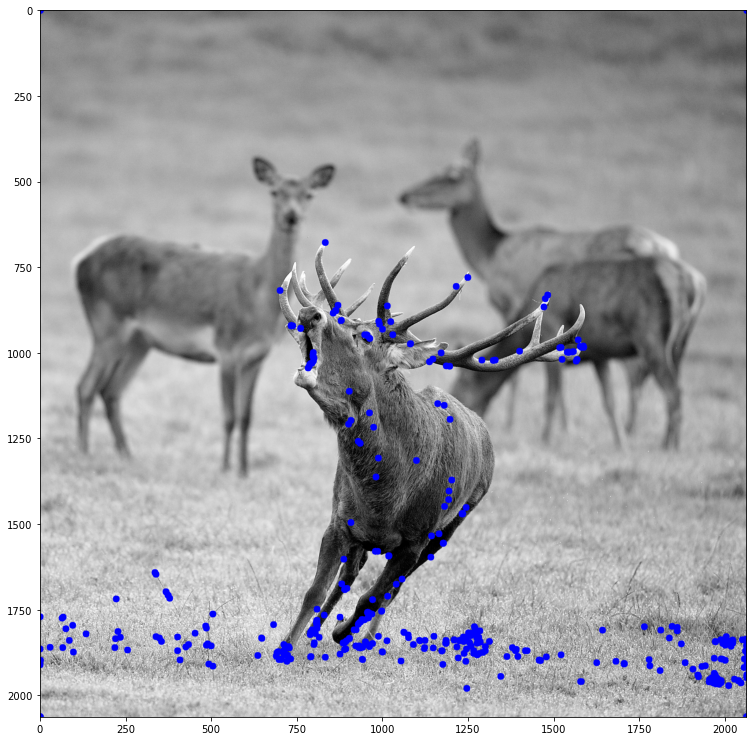

In [7]:
SUSAN_feat = SUSAN(img,0.4)

fig = plt.figure(figsize=(13,13))
plt.imshow(draw_featrue_point(img,SUSAN_feat),cmap='gray')
plt.show()